### Creating health problem words list to verify the NLP model we created.

## Table of contents
1. Extracting health thread words from FDA recall reasons. (2 datasets: FDA press released and FDA enforced.)
2. Categorize the health thread words into food, bacteria, symptom and others groups.
3. From Amazon reviews, extract words that exist in the health thread words we got in 1.

### 1. Extracting health thread words from FDA recall reasons.  (2 datasets: FDA press released and FDA enforced.)

We worked on creating a NLP model to detect reviews about health issues from Amazon reviews. Here, we create verify data to confirm whether the detected results are really related to health problems and whether there are any omissions.  
FDA (The Food and Drug Administration) is responsible for protecting the public health by ensuring the safety, efficacy, and security of human and veterinary drugs, biological products, and medical devices; and by ensuring the safety of our nation's food supply, cosmetics, and products that emit radiation. A recall is a method of removing or correcting products that are in violation of laws administered by the FDA.   
Here, we have data on foods that have been recalled by the FDA in the past, together with recall reason statements. By extracting a word that has been referred to a plurality of times from among the words described in the recall reasoning sentence, it is possible to detect a word related to health in a review about food.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import gensim
import collections
import re
import random
from afinn import Afinn
from wordcloud import WordCloud, STOPWORDS
%matplotlib inline

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tajimakeijiro/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/tajimakeijiro/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
path_press_released = "../data/02_processed/FDA_press_released_2011_2019.csv"
path_enforced = "../data/02_processed/FDA_enforcements_2012-06_to_2019-10.csv"

In [4]:
df_press_released = pd.read_csv(path_press_released)
df_enforced = pd.read_csv(path_enforced, encoding = 'unicode_escape')

In [5]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string

stop_words = set(stopwords.words('english')) 

# stemmer = PorterStemmer()

def process_text(sentence):
    token_words = nltk.word_tokenize(sentence)
    no_stopwords = [word.lower() for word in token_words if word not in stop_words and not \
                    all(c in string.punctuation for c in word) and not len(word) < 2]
    # return [stemmer.stem(word) for word in no_stopwords]
    return [(word) for word in no_stopwords]

print(process_text('I ordered spongbob slippers and I got John'))

['ordered', 'spongbob', 'slippers', 'got', 'john']


In [6]:
stemmed_press_released = df_press_released.copy()
stemmed_press_released['stemmed_Reason'] = stemmed_press_released['Reason'].astype(str).apply(lambda x : process_text(x))
#stemmed_press_released['stemmed_Reason'] = stemmed_press_released['stemmed_Reason'].str.replace('*', ' ')
#stemmed_press_released['stemmed_Reason'] = stemmed_press_released['stemmed_Reason'].str.replace('/', ' ')
stemmed_enforced = df_enforced.copy()
stemmed_enforced['stemmed_Reason.for.Recall'] = stemmed_enforced['Reason.for.Recall'].astype(str).apply(lambda x : process_text(x))

In [7]:
stemmed_press_released.head()

,Unnamed: 0,Date,Brand,ProductDescription,Reason,Company,Url,stemmed_Reason
0,0,"Sat, 31 Dec 2011 22:37:00 -0500","Let&#39;s Grow Healthy Together!, Green Valley...",Sprouts,Listeria monocytogenes,Green Valley Food Corp.,http://wayback.archive-it.org/7993/20170406200...,"[listeria, monocytogenes]"
1,1,"Sat, 31 Dec 2011 00:00:00 -0500",Edelweiss Creamery,cheese,Listeria monocytogenes,Alpine Slicing and Cheese Conversion,http://wayback.archive-it.org/7993/20170406200...,"[listeria, monocytogenes]"
2,2,"Sat, 31 Dec 2011 00:00:00 -0500",Brennan&#39;s Cellars,Cheese,Listeria monocytogenes,Alpine Slicing and Cheese Conversion,http://wayback.archive-it.org/7993/20170406200...,"[listeria, monocytogenes]"
3,3,"Fri, 30 Dec 2011 00:00:00 -0500",Martinelli&#39;s Gold Medal,Sparkling Cider,Defective Seal,S. Martinelli &amp; Company,http://wayback.archive-it.org/7993/20170406200...,"[defective, seal]"
4,4,"Fri, 30 Dec 2011 00:00:00 -0500",Organique by Himalaya,Night Cream,staphylococcus aureus and fungus,HimalayaUSA,http://wayback.archive-it.org/7993/20170406200...,"[staphylococcus, aureus, fungus]"


In [8]:
stemmed_enforced.head()

,Product.Type,Recently.Updated.Record,Last.Modified.Date,Event.ID,Status,Recalling.Firm,Address1,Address2,City,State.Province,...,Product.Description,Product.Quantity,Reason.for.Recall,Recall.Initiation.Date,Center.Classification.Date,Termination.Date,Report.Date,Code.Info,More.Code.Info,stemmed_Reason.for.Recall
0,Food,No,NaN,66563,Terminated,"Reser's Fine Foods, Inc.",15570 SW Jenkins Road,NaN,Beaverton,OR,...,"Macaroni Reg CAD, Formula MA.50, Macaroni Sal...",NaN,The recalled products are potentially contamin...,10/22/2013,12/24/2013,01/24/2017,01/01/2014,Use by dates: 10/21/13-12/11/13.,NaN,"[the, recalled, products, potentially, contami..."
1,Food,No,NaN,66563,Terminated,"Reser's Fine Foods, Inc.",15570 SW Jenkins Road,NaN,Beaverton,OR,...,"Reser's Fine Foods, Cheesy Macaroni Salad, For...",NaN,The recalled products are potentially contamin...,10/22/2013,12/24/2013,01/24/2017,01/01/2014,Use by date 10/20/13 and 12/01/13.,NaN,"[the, recalled, products, potentially, contami..."
2,Food,No,NaN,66563,Terminated,"Reser's Fine Foods, Inc.",15570 SW Jenkins Road,NaN,Beaverton,OR,...,"Reser's Fine Foods, Potato Salad, Formula PO.9...",NaN,The recalled products are potentially contamin...,10/22/2013,12/24/2013,01/24/2017,01/01/2014,Use by date 10/23/13-12/09/13.,NaN,"[the, recalled, products, potentially, contami..."
3,Food,No,NaN,66563,Terminated,"Reser's Fine Foods, Inc.",15570 SW Jenkins Road,NaN,Beaverton,OR,...,"Potato Salad with Egg, Formula PO.71, packaged...",NaN,The recalled products are potentially contamin...,10/22/2013,12/24/2013,01/24/2017,01/01/2014,Use by date 10/20/13 - 12/12/13.,NaN,"[the, recalled, products, potentially, contami..."
4,Food,No,NaN,66563,Terminated,"Reser's Fine Foods, Inc.",15570 SW Jenkins Road,NaN,Beaverton,OR,...,"Potato Salad with Deviled Egg, Formula PO.16, ...",NaN,The recalled products are potentially contamin...,10/22/2013,12/24/2013,01/24/2017,01/01/2014,Use by date 10/13/2013 - 11/15/13.,NaN,"[the, recalled, products, potentially, contami..."


In [9]:
# Define a function that flatten one column into a list
def flatten(nested_list):
    return [e for inner_list in nested_list for e in inner_list]

In [10]:
# Make lists of reason sentences in the press released dataset and the enforced dataset

l_stemmed_press_released = stemmed_press_released['stemmed_Reason'].values.tolist()
l_stemmed_press_released = flatten(l_stemmed_press_released)

l_stemmed_enforced = stemmed_enforced['stemmed_Reason.for.Recall'].values.tolist()
l_stemmed_enforced = flatten(l_stemmed_enforced)

In [11]:
# Function that erases numbers like 2017, 2018, 2019 because they are non related to health problems.
def erase_number(lst):
    l_erased = []
    for word in lst:
        if len(re.sub(r'\d','',word)) > 0:
            l_erased.append(re.sub(r'\d','',word))
    return l_erased

In [12]:
# Erase numbers
l_stemmed_press_released = erase_number(l_stemmed_press_released)
l_stemmed_enforced = erase_number(l_stemmed_enforced)

In [13]:
# Count how many times each word appears in these words lists.
# Remove words that have less than two characters.

press_released_sorted = collections.Counter(l_stemmed_press_released).most_common()
enforced_sorted = collections.Counter(l_stemmed_enforced).most_common()

# Sort these two lists by count
words_press_released_sorted = [word for word, count in press_released_sorted if len(word)>2]
words_enforced_sorted = [word for word, count in enforced_sorted if len(word)>2]

In [14]:
# With using wordcloud library, make a function visualizes the words in these two lists

stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=None 
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(12, 10))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

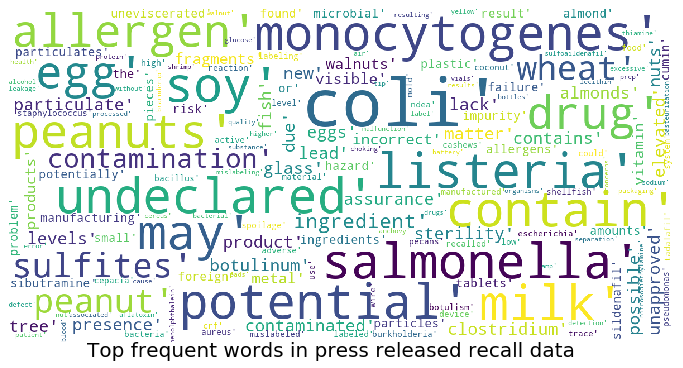

In [15]:
# Visualize the top 200 frequent words in the press released reason sentenses
show_wordcloud(words_press_released_sorted[:200], title = "Top frequent words in press released recall data")

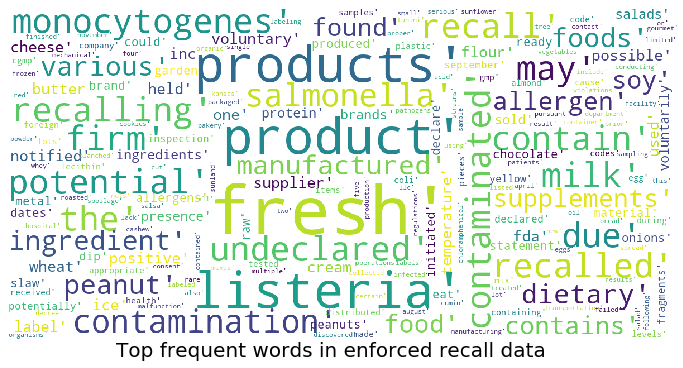

In [16]:
# Visualize the top 200 frequent words in the enforced reason sentenses
show_wordcloud(words_enforced_sorted[:200], title = "Top frequent words in enforced recall data")

## 2. Categorize the health thread words into food, bacteria, symptom and others groups

We categorized words that appeared in sentences explaining the reasons for FDA recall. To identify word categories, we used the following existing data sets.   
Especially for pathogens and diseases names, the existing datasets were too specialized (for doctors, hospitals, and related research institutions). However, in Amazon reviews, it is highly anticipated that most customers will use simpler words. Therefore, we aimed to eliminate these omissions by using data from websites containing general terms in addition to the technical term data set.

**Pathogen and disease words (e.g. salmonella)**
- EU safe food: https://www.safefood.eu/SafeFood/media/SafeFoodLibrary/Documents/Education/safefood%20for%20life/NI/section2_1.pdf
- Foodsafety.gov bacteria and viruses words: https://www.foodsafety.gov/food-poisoning/bacteria-and-viruses
- CDC foodborne illness words: https://www.cdc.gov/foodsafety/diseases/index.html
- CDC national outbreak reporting system: https://wwwn.cdc.gov/norsdashboard/  

**Symptom words (e.g. embolism)**
- EU safe food: https://www.safefood.eu/SafeFood/media/SafeFoodLibrary/Documents/Education/safefood%20for%20life/NI/section2_1.pdf
- Foodsafety.gov symptom words: https://www.foodsafety.gov/food-poisoning
- symptom dictionary: https://github.com/sekharvth/symptom-disease

**Food words (e.g. egg)**
- Exhaustive list of all foods & food items in the world: https://github.com/CurtisGrayeBabin/List-of-all-Foods

In [31]:
# Import words datasets for categorizing

# Import pathogen and disease words
path_pathogen_EU = "../data/02_processed/pathogenic_bacteria.csv" # EU safe food
path_pathogen_Foodsafety = "../data/02_processed/Foodsafety_gov_Bacteria_viruses.csv" # Foodsafety.gov bacteria and viruses words
path_pathogen_CDC = "../data/02_processed/CDC_A-Z_Index_for_Foodborne_Illness.xlsx" # CDC foodborne illness words
path_pathogen_CDC_outbreak = "../data/02_processed/NationalOutbreakPublicDataTool.xlsx" # CDC national outbreak reporting system

# Import symptom words
path_symptom_EU = "../data/02_processed/typical_symptoms.csv" # EU safe food
path_symptom_Foodsafety = "../data/02_processed/Foodsafety_gov_symptom.csv" # # Foodsafety.gov symptom words
path_symptom_github = "../data/02_processed/Dictionary.csv" # Symptom words from a github dataset

# Import food words
path_all_food = "../data/02_processed/FOOD.txt" # Exhaustive list of all foods & food items in the world

In [32]:
# Read pathogen and disease files
df_pathogen_EU = pd.read_csv(path_pathogen_EU, header=None, sep=';')
df_pathogen_Foodsafety = pd.read_csv(path_pathogen_Foodsafety, sep=';')
df_pathogen_CDC = pd.read_excel(path_pathogen_CDC, index_col=0)
df_pathogen_CDC_outbreak = pd.read_excel(path_pathogen_CDC_outbreak, index_col=0)

# Read symptom files
df_symptom_EU = pd.read_csv(path_symptom_EU, header=None, sep=";")
df_symptom_Foodsafety = pd.read_csv(path_symptom_Foodsafety, sep=';')
df_symptom_github = pd.read_csv(path_symptom_github, sep=',')

# Read food files
df_all_food = pd.read_table(path_all_food, header=None)

In [33]:
# Let's see the content of df_pathogen_EU as an example
df_pathogen_CDC_outbreak.head()

,Month,State,Primary Mode,Etiology,Serotype or Genotype,Etiology Status,Setting,Illnesses,Hospitalizations,Info on Hospitalizations,Deaths,Info on Deaths,Food Vehicle,Food Contaminated Ingredient,IFSAC Category,Water Exposure,Water Type,Animal Type,Animal Type Specify,Water Status
Year,,,,,,,,,,,,,,,,,,,,
2009,1,Minnesota,Person-to-person,Norovirus Genogroup II,unknown,Confirmed,Hotel/motel,21,0.0,19.0,0.0,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009,1,Minnesota,Food,Norovirus,NaN,Suspected,Restaurant - Sit-down dining,2,0.0,2.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009,2,Minnesota,Person-to-person,Norovirus,NaN,Suspected,"Other, specify",50,0.0,0.0,0.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009,1,Minnesota,Person-to-person,Norovirus unknown,NaN,Confirmed,Restaurant,24,0.0,24.0,0.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009,1,Minnesota,Food,Norovirus,NaN,Confirmed,NaN,16,0.0,8.0,0.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
# Stemmed all the dataframes

stemmed_pathogen_EU = df_pathogen_EU[0].astype(str).apply(lambda x : process_text(x))
stemmed_pathogen_Foodsafety = df_pathogen_Foodsafety['name'].astype(str).apply(lambda x : process_text(x))
stemmed_pathogen_CDC_outbreak = df_pathogen_CDC_outbreak['Etiology'].astype(str).apply(lambda x : process_text(x))

stemmed_symptom_EU = df_symptom_EU[0].astype(str).apply(lambda x : process_text(x))
stemmed_symptom_Foodsafety = df_symptom_Foodsafety['symptom names'].astype(str).apply(lambda x : process_text(x))
stemmed_symptom_github = df_symptom_github['Key'].astype(str).apply(lambda x : process_text(x))

stemmed_all_food = df_all_food[0].astype(str).apply(lambda x : process_text(x))

In [35]:
df_pathogen_CDC = df_pathogen_CDC[df_pathogen_CDC.index != 'ignore']
df_pathogen_CDC.head()

,name,disease,disease_2,pathogenesis,pathogenesis_2
category,,,,,
disease,Amebiasis,Amebiasis,NaN,NaN,NaN
disease,Anisakiasis,Anisakiasis,NaN,NaN,NaN
disease/pathogenesis,Ascariasis (Intestinal roundworm infection),Ascariasis,NaN,Intestinal roundworm,NaN
disease/pathogenesis,Angiostrongyliasis (Rat lungworm),Angiostrongyliasis,NaN,Rat lungworm,NaN
disease,Anthrax,Anthrax,NaN,NaN,NaN


In [36]:
# For df_pathogen_CDC, since we had to get information from multiple columns, we processed it separately.
df_pathogen_CDC = df_pathogen_CDC[df_pathogen_CDC.index != 'ignore']
df1 = df_pathogen_CDC['disease'].astype(str).apply(lambda x : process_text(x))
df2 = df_pathogen_CDC['disease_2'].astype(str).apply(lambda x : process_text(x))
df3 = df_pathogen_CDC['pathogenesis'].astype(str).apply(lambda x : process_text(x))
df4 = df_pathogen_CDC['pathogenesis_2'].astype(str).apply(lambda x : process_text(x))
stemmed_pathogen_CDC = pd.concat([df1, df2, df3, df4], axis=0)

In [79]:
# Concatenate these datasets for scoring reviews which will be done in other notebook
pathogen_words = pd.concat([stemmed_pathogen_EU.explode(), stemmed_pathogen_Foodsafety.explode(), 
                            stemmed_pathogen_CDC.explode()[stemmed_pathogen_CDC.explode() != 'nan'],
                            stemmed_pathogen_CDC_outbreak.explode()[stemmed_pathogen_CDC_outbreak.explode() != 'nan']], axis=0)
pathogen_words = pathogen_words[pathogen_words.duplicated() == False]
pathogen_words = pathogen_words[pathogen_words.apply(lambda x: len(x)) > 2]
pathogen_words = pathogen_words.reset_index()[0]
print(len(pathogen_words))

180


In [81]:
# Concatenate these datasets for scoring reviews which will be done in other notebook
symptom_words = pd.concat([stemmed_symptom_EU.explode(), stemmed_symptom_Foodsafety.explode(), 
                             stemmed_symptom_github.explode()], axis=0)
symptom_words = symptom_words[symptom_words.duplicated() == False]
symptom_words = symptom_words.reset_index()[0]
print(len(symptom_words))

319


In [82]:
pd.DataFrame(pathogen_words).to_csv('../data/02_processed/pathogen_disease_dictionary.csv', index=False)
pd.DataFrame(symptom_words).to_csv('../data/02_processed/symptom_dictionary.csv', index=False)

In [40]:
# Define a function that check whether the dataframe has words in recalled reasons

def check_words(words_lst, stemmed_df):
    result = []
    for word in words_lst:
        if stemmed_df.apply(lambda x: word in x).sum() > 0:
            result.append(word)
    return result

In [41]:
# Copy the press released words list
words_press_released_sorted_new = words_press_released_sorted.copy()

In [43]:
# Check whether the dataframe has words in recalled reasons

FDA_pathogen_EU_lst = check_words(words_press_released_sorted_new, stemmed_pathogen_EU)
FDA_pathogen_Foodsafety_lst = check_words(words_press_released_sorted_new, stemmed_pathogen_Foodsafety)
FDA_pathogen_CDC_lst = check_words(words_press_released_sorted_new, stemmed_pathogen_CDC)
FDA_pathogen_CDC_outbreak_lst = check_words(words_press_released_sorted_new, stemmed_pathogen_CDC_outbreak)
FDA_pathogen_disease_set = set(FDA_pathogen_EU_lst + FDA_pathogen_Foodsafety_lst + FDA_pathogen_CDC_lst + FDA_pathogen_CDC_outbreak_lst)

FDA_symptom_EU_lst = check_words(words_press_released_sorted_new, stemmed_symptom_EU)
FDA_symptom_Foodsafety_lst = check_words(words_press_released_sorted_new, stemmed_symptom_Foodsafety)
FDA_symptom_github_lst = check_words(words_press_released_sorted_new, stemmed_symptom_github)
FDA_symptom_set = set(FDA_symptom_EU_lst + FDA_symptom_Foodsafety_lst + FDA_symptom_github_lst)

FDA_all_food_lst = check_words(words_press_released_sorted_new, stemmed_all_food)
FDA_food_set = set(FDA_all_food_lst)

In [44]:
# Let's see head of the pathogen and disease words list
random.sample(FDA_pathogen_disease_set, 10)

['botulism',
 'hepatitis',
 'e.coli',
 'mycobacterium',
 'cereus',
 'botulinum',
 'escherichia',
 'norovirus',
 'group',
 'histamine']

In [45]:
# Let's see head of the symptom words list
random.sample(FDA_symptom_set, 10)

['acute',
 'death',
 'airway',
 'infection',
 'valve',
 'cell',
 'visual',
 'cells',
 'like',
 'changes']

In [50]:
# Let's see head of the food words list
random.sample(FDA_food_set, 10)

['lemon',
 'whey',
 'sesame',
 'oats',
 'shredded',
 'floating',
 'real',
 'made',
 'production',
 'fan']

In [51]:
words_press_released_sorted_remained = set(words_press_released_sorted_new) - FDA_pathogen_disease_set - FDA_symptom_set - FDA_food_set

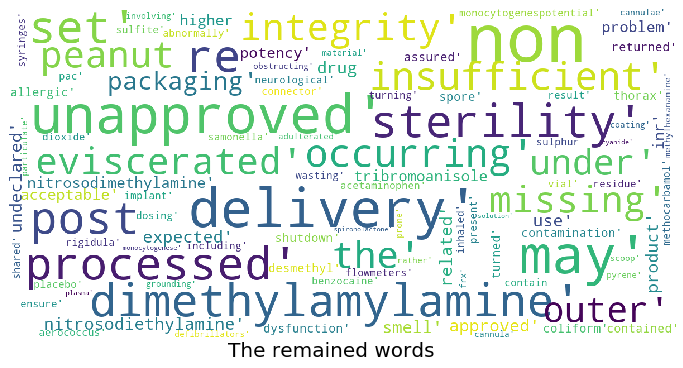

In [49]:
# tribromoanisole, nitrosodimethylamine should be in the bacteria list
show_wordcloud(list(words_press_released_sorted_remained), title = "The remained words")

In [52]:
# Output all the categorized words lists to CSV files.
pd.DataFrame(FDA_pathogen_disease_set).to_csv('../data/02_processed/FDA_pathogen_disease_words.csv', index=False)
pd.DataFrame(FDA_symptom_set).to_csv('../data/02_processed/FDA_symptom_words.csv', index=False)
pd.DataFrame(FDA_food_set).to_csv('../data/02_processed/FDA_food_words.csv', index=False)

In [312]:
len(words_press_released_sorted_remained)

1124

## 3. From Amazon reviews, extract words that exist in the health thread words we got in 1.

Here, we got words lists from both the press released dataset and the enforced dataset. We can see that these words strongly connect to health problems.  
Then, in these lists, there might be some usuless words that appear few times. Let's check these words and delete them.

In [193]:
# Count all of the words in each list
counts_press_released = pd.Series([count for word, count in press_released_sorted if len(word)>2])
counts_enforced = pd.Series([count for word, count in enforced_sorted if len(word)>2])

Text(0.5, 1.0, 'Histogram of counts of words appear in the enforced dataset')

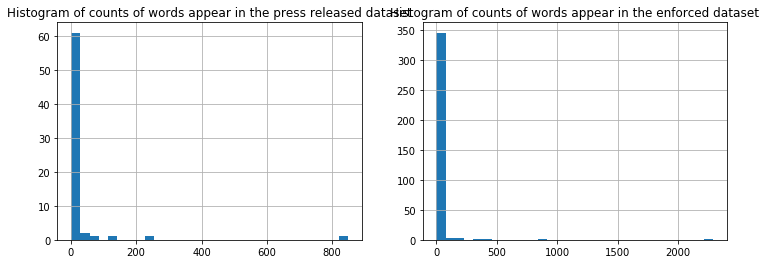

In [194]:
# Plot the histograms of word counts in each list
plt.figure(figsize=(12, 4))

plt.subplot(1,2,1)
counts_press_released.value_counts().hist(bins=30)
plt.title("Histogram of counts of words appear in the press released dataset")

plt.subplot(1,2,2)
counts_enforced.value_counts().hist(bins=30)
plt.title("Histogram of counts of words appear in the enforced dataset")

In [195]:
print("The ratio of words that appear only once in words_press_released_sorted is {:.1f}%".format(counts_press_released.value_counts()[1]/len(words_press_released_sorted)*100))
print("The ratio of words that appear only once in words_enforced_sorted is {:.1f}%".format(counts_enforced.value_counts()[1]/len(words_enforced_sorted)*100))

The ratio of words that appear only once in words_press_released_sorted is 55.5%
The ratio of words that appear only once in words_enforced_sorted is 34.5%


In [196]:
# Let's see inside the press released  word list with specified word count 2 & 3
words_press_released_3 = [word for word, count in press_released_sorted if count==3 if len(word)>2]
words_press_released_4 = [word for word, count in press_released_sorted if count==4 if len(word)>2]

In [197]:
# Let's see inside the enforced word list with specified word count 5 & 10
words_enforced_5 = [word for word, count in enforced_sorted if count==5 if len(word)>2]
words_enforced_10 = [word for word, count in enforced_sorted if count==10 if len(word)>2]
words_enforced_15 = [word for word, count in enforced_sorted if count==15 if len(word)>2]

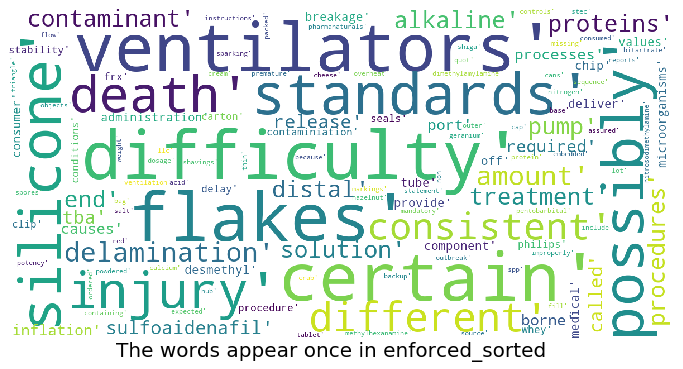

In [198]:
show_wordcloud(words_press_released_3, title = "The words appear once in enforced_sorted")

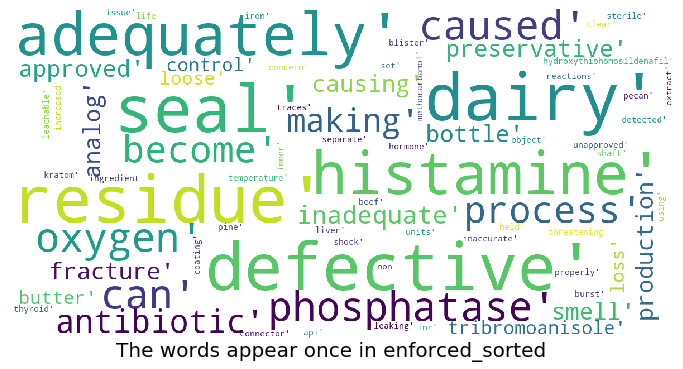

In [199]:
show_wordcloud(words_press_released_4, title = "The words appear once in enforced_sorted")

Here, from count more than 4, the useless words ratio like "become" and "process" is small. (When we increase the minimum count like 10, we still have some useless words, so we analyzed compromise point to get useful health words.)

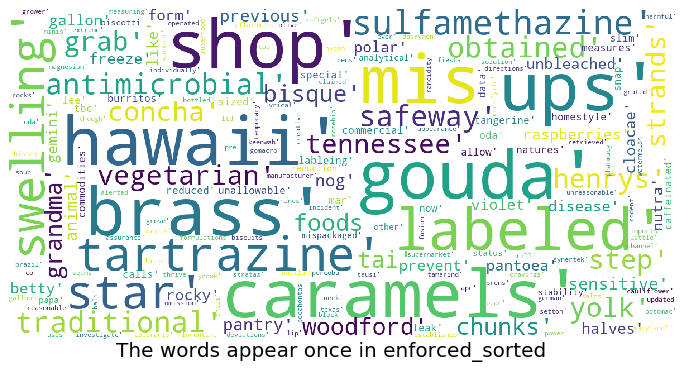

In [200]:
show_wordcloud(words_enforced_5, title = "The words appear once in enforced_sorted")

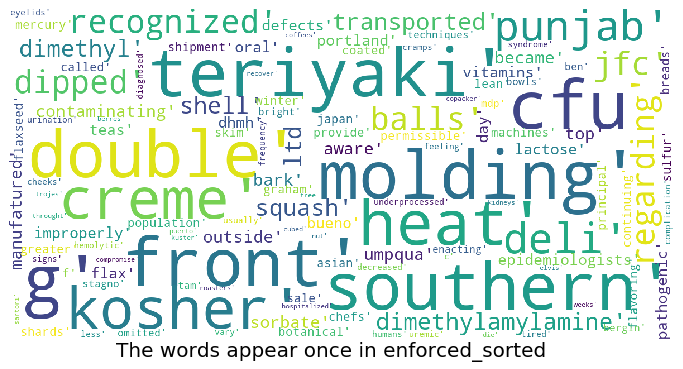

In [201]:
show_wordcloud(words_enforced_10, title = "The words appear once in enforced_sorted")

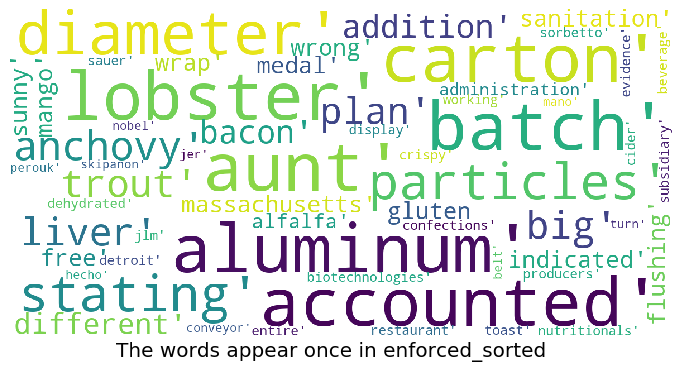

In [202]:
show_wordcloud(words_enforced_15, title = "The words appear once in enforced_sorted")

Here, from count more than 15, the useless words ratio like "14" and "massachusetts" is small. (When we increase the minimum count like 20, we still have some useless words, so we analyzed compromise point to get useful health words.)

In [203]:
frequent_words_press_released = [word for word, count in press_released_sorted if count >= 4 if len(word)>2]
frequent_words_enforced = [word for word, count in enforced_sorted if count >= 30  if len(word)>2]

In [204]:
# # This cell is for making cleaned_reviews.json file. If you already have this, you don't need to run this cell.
# # If you want to run, to remove all # at once, "command + a" -> "command + /".

# #AMAZON DATA
# REVIEWS_PATH = "../data/02_processed/reviews_Grocery_and_Gourmet_Food.json.gz"
# META_PATH = "../data/02_processed/meta_Grocery_and_Gourmet_Food.json.gz"
# #FDA DATA
# path_press_released = "/Users/tajimakeijiro/Desktop/amazon_project/Amazon-Reviews-Infectious-Disease/data/02_processed/FDA_press_released_2011_2019.csv"
# path_enforced = "/Users/tajimakeijiro/Desktop/amazon_project/Amazon-Reviews-Infectious-Disease/data/02_processed/FDA_enforcements_2012-06_to_2019-10.csv"

# def sanitize(path, outpath):
#     """Converts a given compressed json to strict json and writes it in a new file

#     Parameters
#     ----------
#     path : str
#     The file location of the gzip-compressed json file
#     outpath : str
#     The path to the desired output file location 

#     """
#     g = gzip.open(path, 'r')

#     out = open(outpath, 'w')

#     for l in g:
#         out.write(json.dumps(eval(l)) + '\n')
#     out.close()
    
# META_OUTPATH = "cleaned_meta.json"
# REVIEWS_OUTPATH = "cleaned_reviews.json"

# sanitize(META_PATH, META_OUTPATH)
# sanitize(REVIEWS_PATH, REVIEWS_OUTPATH)

In [205]:
path_amazon = "./cleaned_reviews.json" 
df_reviews = pd.read_json(path_amazon, lines=True)
df_reviews.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1ZQZ8RJS1XVTX,0657745316,gsxrgirl,"[0, 0]","No sugar, no GMO garbage, no fillers that come...",5,Best vanilla I've ever had,1381449600,"10 11, 2013"
1,A31W38VGZAUUM4,0700026444,FIFA Lvr,"[1, 1]","This is my absolute, undisputed favorite tea r...",5,Terrific Tea!,1354752000,"12 6, 2012"
2,A3I0AV0UJX5OH0,1403796890,Alicia b,"[0, 0]",I ordered spongbob slippers and I got John Cen...,1,grrrrrrr,1385942400,"12 2, 2013"
3,A3QAAOLIXKV383,1403796890,"Danny K. Tilley ""Dan Tilley""","[0, 0]",The cart is fine and works for the purpose for...,3,Storage on Wheels Cart,1307836800,"06 12, 2011"
4,AB1A5EGHHVA9M,141278509X,CHelmic,"[1, 1]",This product by Archer Farms is the best drink...,5,The best drink mix,1332547200,"03 24, 2012"


In [206]:
#Download stopwords and wordnet for lemmatization (only need to be executed once)
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tajimakeijiro/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/tajimakeijiro/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [207]:
reviews = df_reviews

#TBD: Which columns to keep/remove
reviews = reviews.drop(columns=['reviewerName', 'helpful', 'reviewTime'])

#Convert the utc timestamp to readable dates
reviews['unixReviewTime'] = pd.to_datetime(reviews['unixReviewTime'],unit='s')

reviews.head()

,reviewerID,asin,reviewText,overall,summary,unixReviewTime
0,A1ZQZ8RJS1XVTX,0657745316,"No sugar, no GMO garbage, no fillers that come...",5,Best vanilla I've ever had,2013-10-11
1,A31W38VGZAUUM4,0700026444,"This is my absolute, undisputed favorite tea r...",5,Terrific Tea!,2012-12-06
2,A3I0AV0UJX5OH0,1403796890,I ordered spongbob slippers and I got John Cen...,1,grrrrrrr,2013-12-02
3,A3QAAOLIXKV383,1403796890,The cart is fine and works for the purpose for...,3,Storage on Wheels Cart,2011-06-12
4,AB1A5EGHHVA9M,141278509X,This product by Archer Farms is the best drink...,5,The best drink mix,2012-03-24


In [208]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string

stop_words = set(stopwords.words('english')) 

# Here we don't need stemming, because Afinn has same score for the before stemmed ones.
# stemmer = PorterStemmer()

def process_text(sentence):
    token_words = nltk.word_tokenize(sentence)
    no_stopwords = [word.lower() for word in token_words if word not in stop_words and not \
                    all(c in string.punctuation for c in word) and not len(word) < 2]
    # return [stemmer.stem(word) for word in no_stopwords]
    return [(word) for word in no_stopwords]

print(process_text('I ordered spongbob slippers and I got John'))

['ordered', 'spongbob', 'slippers', 'got', 'john']


In [213]:
stemmed = reviews.copy()
stemmed = stemmed[stemmed['overall'] < 3]
stemmed['reviewStemmed'] = stemmed['reviewText'].apply(lambda x : process_text(x))

stemmed.head()

,reviewerID,asin,reviewText,overall,summary,unixReviewTime,reviewStemmed
2,A3I0AV0UJX5OH0,1403796890,I ordered spongbob slippers and I got John Cen...,1,grrrrrrr,2013-12-02,"[ordered, spongbob, slippers, got, john, cena,..."
5,A3DTB6RVENLQ9Q,1453060375,Don't buy this item - rip off at this price. ...,1,Oops. Made a mistake and ordered this. I mis...,2013-03-03,"[do, n't, buy, item, rip, price, my, bad, mist..."
46,A3KJ9TZ2HLL7SA,5901002482,I wrote an earlier scathing review of this pro...,1,Packaging problem,2012-11-28,"[wrote, earlier, scathing, review, product, wh..."
48,ACEL2LY99MAB0,6162362183,I read the reviews before I bought it. It got ...,2,Very disappointed.,2014-04-21,"[read, reviews, bought, it, got, excited, revi..."
61,A2F3CK8F9VIFPL,616719923X,I bought it because i like green tea but the t...,1,Yuck,2013-07-29,"[bought, like, green, tea, taste, bad, came, m..."


In [223]:
stemmed['reviewStemmed']

2          [ordered, spongbob, slippers, got, john, cena,...
5          [do, n't, buy, item, rip, price, my, bad, mist...
46         [wrote, earlier, scathing, review, product, wh...
48         [read, reviews, bought, it, got, excited, revi...
61         [bought, like, green, tea, taste, bad, came, m...
                                 ...                        
1297114    [disgusting, simple, turns, thick, gross, prod...
1297125          [nasty, tasting, threw, away, first, drink]
1297131    [really, looking, forward, receiving, product,...
1297134    [not, best, chai, taste, pretty, grainy, is, o...
1297139    [for, six, months, struggling, inexplicable, s...
Name: reviewStemmed, Length: 164492, dtype: object

In [232]:
stemmed['reviewStemmed'].explode().isin(['wheat']).sum()

2005

In [ ]:
stemmed['FDA_press_released'] = stemmed['reviewStemmed'].apply(lambda x: [i for i in x if i in frequent_words_press_released])
stemmed['FDA_enforced'] = stemmed['reviewStemmed'].apply(lambda x: [i for i in x if i in frequent_words_enforced])

In [ ]:
stemmed.head()

Eventually, from the Amazon review , we were able to extract the most frequent words listed as the reason for recall in FDA datasets. On the other hand, even if they are not related to food problems, there are some words that appear frequently in the recall reasons. Especially for the FDA_enforced, we got so many useless words. This couldn't be solved by increasing the minimum count. The next step will be to consider how to remove them.

In [ ]:
l_stemmed_press_released = stemmed['FDA_press_released'].values.tolist()
l_stemmed_press_released = flatten(l_stemmed_press_released)

l_stemmed_enforced = stemmed['FDA_enforced'] .values.tolist()
l_stemmed_enforced = flatten(l_stemmed_enforced)

In [ ]:
print(len(l_stemmed_press_released))

In [ ]:
print(len(l_stemmed_enforced))

### For UI, make health thread words lists.
From FDA datasets, we extracted the words which occured frequently in recall reasons as health thread words.

In [143]:
# Health thread words from the press released dataset.
health_thread_words_press_released = set(l_stemmed_press_released)
print(random.sample(health_thread_words_press_released, 5))

['assurance', 'separation', 'recently', 'antibiotic', 'coating']


In [144]:
# Health thread words from the enforced dataset.
health_thread_words_enforced = set(l_stemmed_enforced)
print(random.sample(health_thread_words_enforced, 5))

['peas', 'tuna', 'caramel', 'declaration', 'greek']


In [150]:
df = pd.DataFrame([health_thread_words_press_released, health_thread_words_enforced], index=["Press_released", "Enforced"])

In [152]:
df.to_csv('../data/02_processed/Health_thread_words.csv')